# Grad-CAM implementation in Pytorch 
based on this [git-repo](https://github.com/jacobgil/pytorch-grad-cam).

In [2]:
#@title imports
import setGPU
import torch
import argparse
import cv2
import numpy as np
from torch.autograd import Function
from torchvision import models, transforms

setGPU: Setting GPU to: 0


In [9]:
class FeatureExtractor():
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x

class ModelOutputs():
    """ Class for making a forward pass, and getting:
    1. The network output.
    2. Activations from intermeddiate targetted layers.
    3. Gradients from intermeddiate targetted layers. """

    def __init__(self, model, feature_module, target_layers):
        self.model = model
        self.feature_module = feature_module
        self.feature_extractor = FeatureExtractor(self.feature_module, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations = []
        for name, module in self.model._modules.items():
            if module == self.feature_module:
                target_activations, x = self.feature_extractor(x)
            elif "avgpool" in name.lower():
                x = module(x)
                x = x.view(x.size(0),-1)
            else:
                x = module(x)

        return target_activations, x

def preprocess_image(img):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    preprocessing = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])
    return preprocessing(img.copy()).unsqueeze(0)

def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

class GradCam:
    def __init__(self, model, feature_module, target_layer_names, use_cuda):
        self.model = model
        self.feature_module = feature_module
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        self.extractor = ModelOutputs(self.model, self.feature_module, target_layer_names)

    def forward(self, input_img):
        return self.model(input_img)

    def __call__(self, input_img, target_category=None):
        if self.cuda:
            input_img = input_img.cuda()

        features, output = self.extractor(input_img)

        if target_category == None:
            target_category = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][target_category] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = one_hot.cuda()
        
        one_hot = torch.sum(one_hot * output)
        self.feature_module.zero_grad()
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)
        
        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()
        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input_img.shape[2:])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam


class GuidedBackpropReLU(Function):
    @staticmethod
    def forward(self, input_img):
        positive_mask = (input_img > 0).type_as(input_img)
        output = torch.addcmul(torch.zeros(input_img.size()).type_as(input_img), input_img, positive_mask)
        self.save_for_backward(input_img, output)
        return output

    @staticmethod
    def backward(self, grad_output):
        input_img, output = self.saved_tensors
        grad_input = None

        positive_mask_1 = (input_img > 0).type_as(grad_output)
        positive_mask_2 = (grad_output > 0).type_as(grad_output)
        grad_input = torch.addcmul(torch.zeros(input_img.size()).type_as(input_img),
                                   torch.addcmul(torch.zeros(input_img.size()).type_as(input_img), grad_output,
                                                 positive_mask_1), positive_mask_2)
        return grad_input


class GuidedBackpropReLUModel:
    def __init__(self, model, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        def recursive_relu_apply(module_top):
            for idx, module in module_top._modules.items():
                recursive_relu_apply(module)
                if module.__class__.__name__ == 'ReLU':
                    module_top._modules[idx] = GuidedBackpropReLU.apply

        # replace ReLU with GuidedBackpropReLU
        recursive_relu_apply(self.model)

    def forward(self, input_img):
        return self.model(input_img)

    def __call__(self, input_img, target_category=None):
        if self.cuda:
            input_img = input_img.cuda()

        input_img = input_img.requires_grad_(True)

        output = self.forward(input_img)

        if target_category == None:
            target_category = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][target_category] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = one_hot.cuda()

        one_hot = torch.sum(one_hot * output)
        one_hot.backward(retain_graph=True)

        output = input_img.grad.cpu().data.numpy()
        output = output[0, :, :, :]

        return output

def deprocess_image(img):
    """ see https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py#L65 """
    img = img - np.mean(img)
    img = img / (np.std(img) + 1e-5)
    img = img * 0.1
    img = img + 0.5
    img = np.clip(img, 0, 1)
    return np.uint8(img*255)

def grad_cam(image_path, use_cuda=False):
    """ python grad_cam.py <path_to_image>
    1. Loads an image with opencv.
    2. Preprocesses it for VGG19 and converts to a pytorch variable.
    3. Makes a forward pass to find the category index with the highest score,
    and computes intermediate activations.
    Makes the visualization. """

    use_cuda = use_cuda and torch.cuda.is_available()

    model = models.resnet50(pretrained=True)  # <-- Which model?
    grad_cam = GradCam(model=model, feature_module=model.layer4, \
                       target_layer_names=["2"], use_cuda=use_cuda)

    img = cv2.imread(image_path, 1)
    img = np.float32(img) / 255
    # Opencv loads as BGR:
    img = img[:, :, ::-1]
    input_img = preprocess_image(img)

    # If None, returns the map for the highest scoring category.
    # Otherwise, targets the requested category.
    target_category = None
    grayscale_cam = grad_cam(input_img, target_category)

    grayscale_cam = cv2.resize(grayscale_cam, (img.shape[1], img.shape[0]))
    cam = show_cam_on_image(img, grayscale_cam)

    gb_model = GuidedBackpropReLUModel(model=model, use_cuda=use_cuda)
    gb = gb_model(input_img, target_category=target_category)
    gb = gb.transpose((1, 2, 0))

    cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
    cam_gb = deprocess_image(cam_mask*gb)
    gb = deprocess_image(gb)

    cv2.imwrite("cam.jpg", cam)
    cv2.imwrite('gb.jpg', gb)
    cv2.imwrite('cam_gb.jpg', cam_gb)

# Test

<img src='https://drive.google.com/uc?id=11KO3HJ2qITLfpF04UD8o-i8X-qkUXrS-'>

In [10]:
class FeatureExtractor():
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x

In [13]:
image_path='wolf.png'
#model = models.resnet50(pretrained=True)  # <-- Which model?
#grad_cam = GradCam(model=model, feature_module=model.layer4, \
#                   target_layer_names=["2"], use_cuda=use_cuda)

img = cv2.imread(image_path, 1)
img = np.float32(img) / 255
# Opencv loads as BGR:
img = img[:, :, ::-1]
input_img = preprocess_image(img)

#extractor = FeatureExtractor(model=model.layer4, target_layers=["2"])
#extractor.gradients

In [14]:
#@title download the above image on coloab server
#!gdown --id 11KO3HJ2qITLfpF04UD8o-i8X-qkUXrS-
#!ls

In [15]:
#@title run grad-cam
grad_cam(image_path='wolf.png', use_cuda=False)

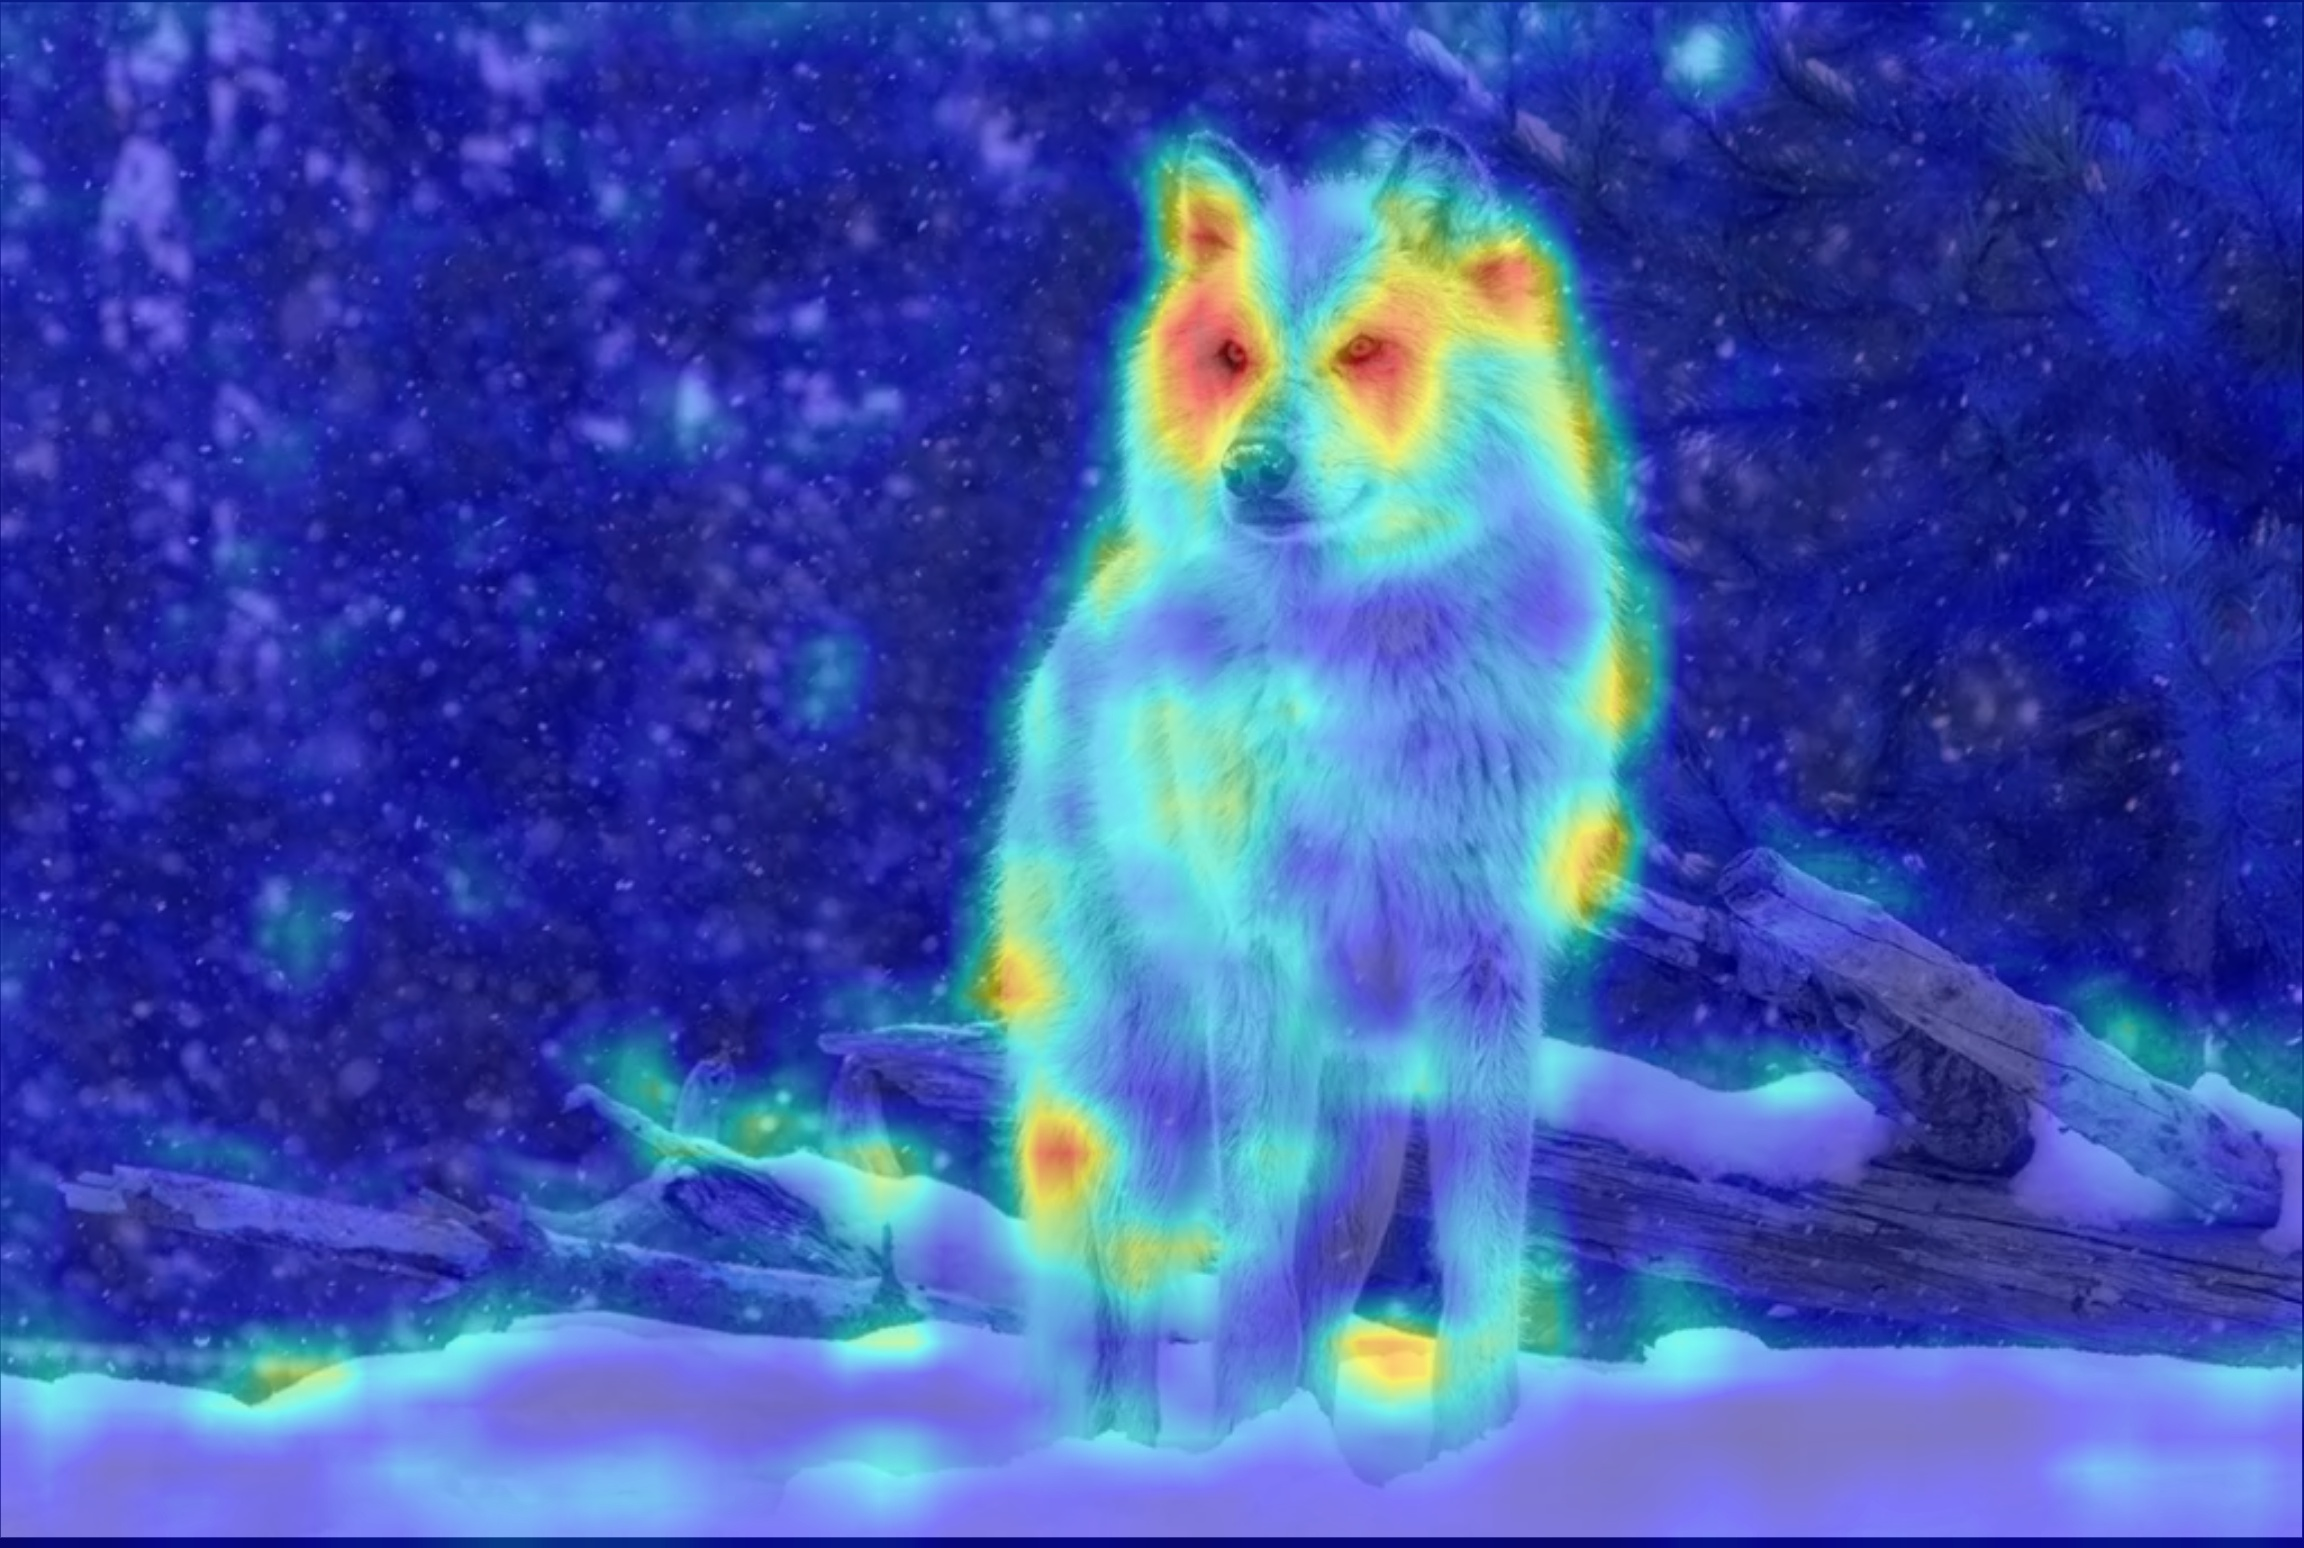

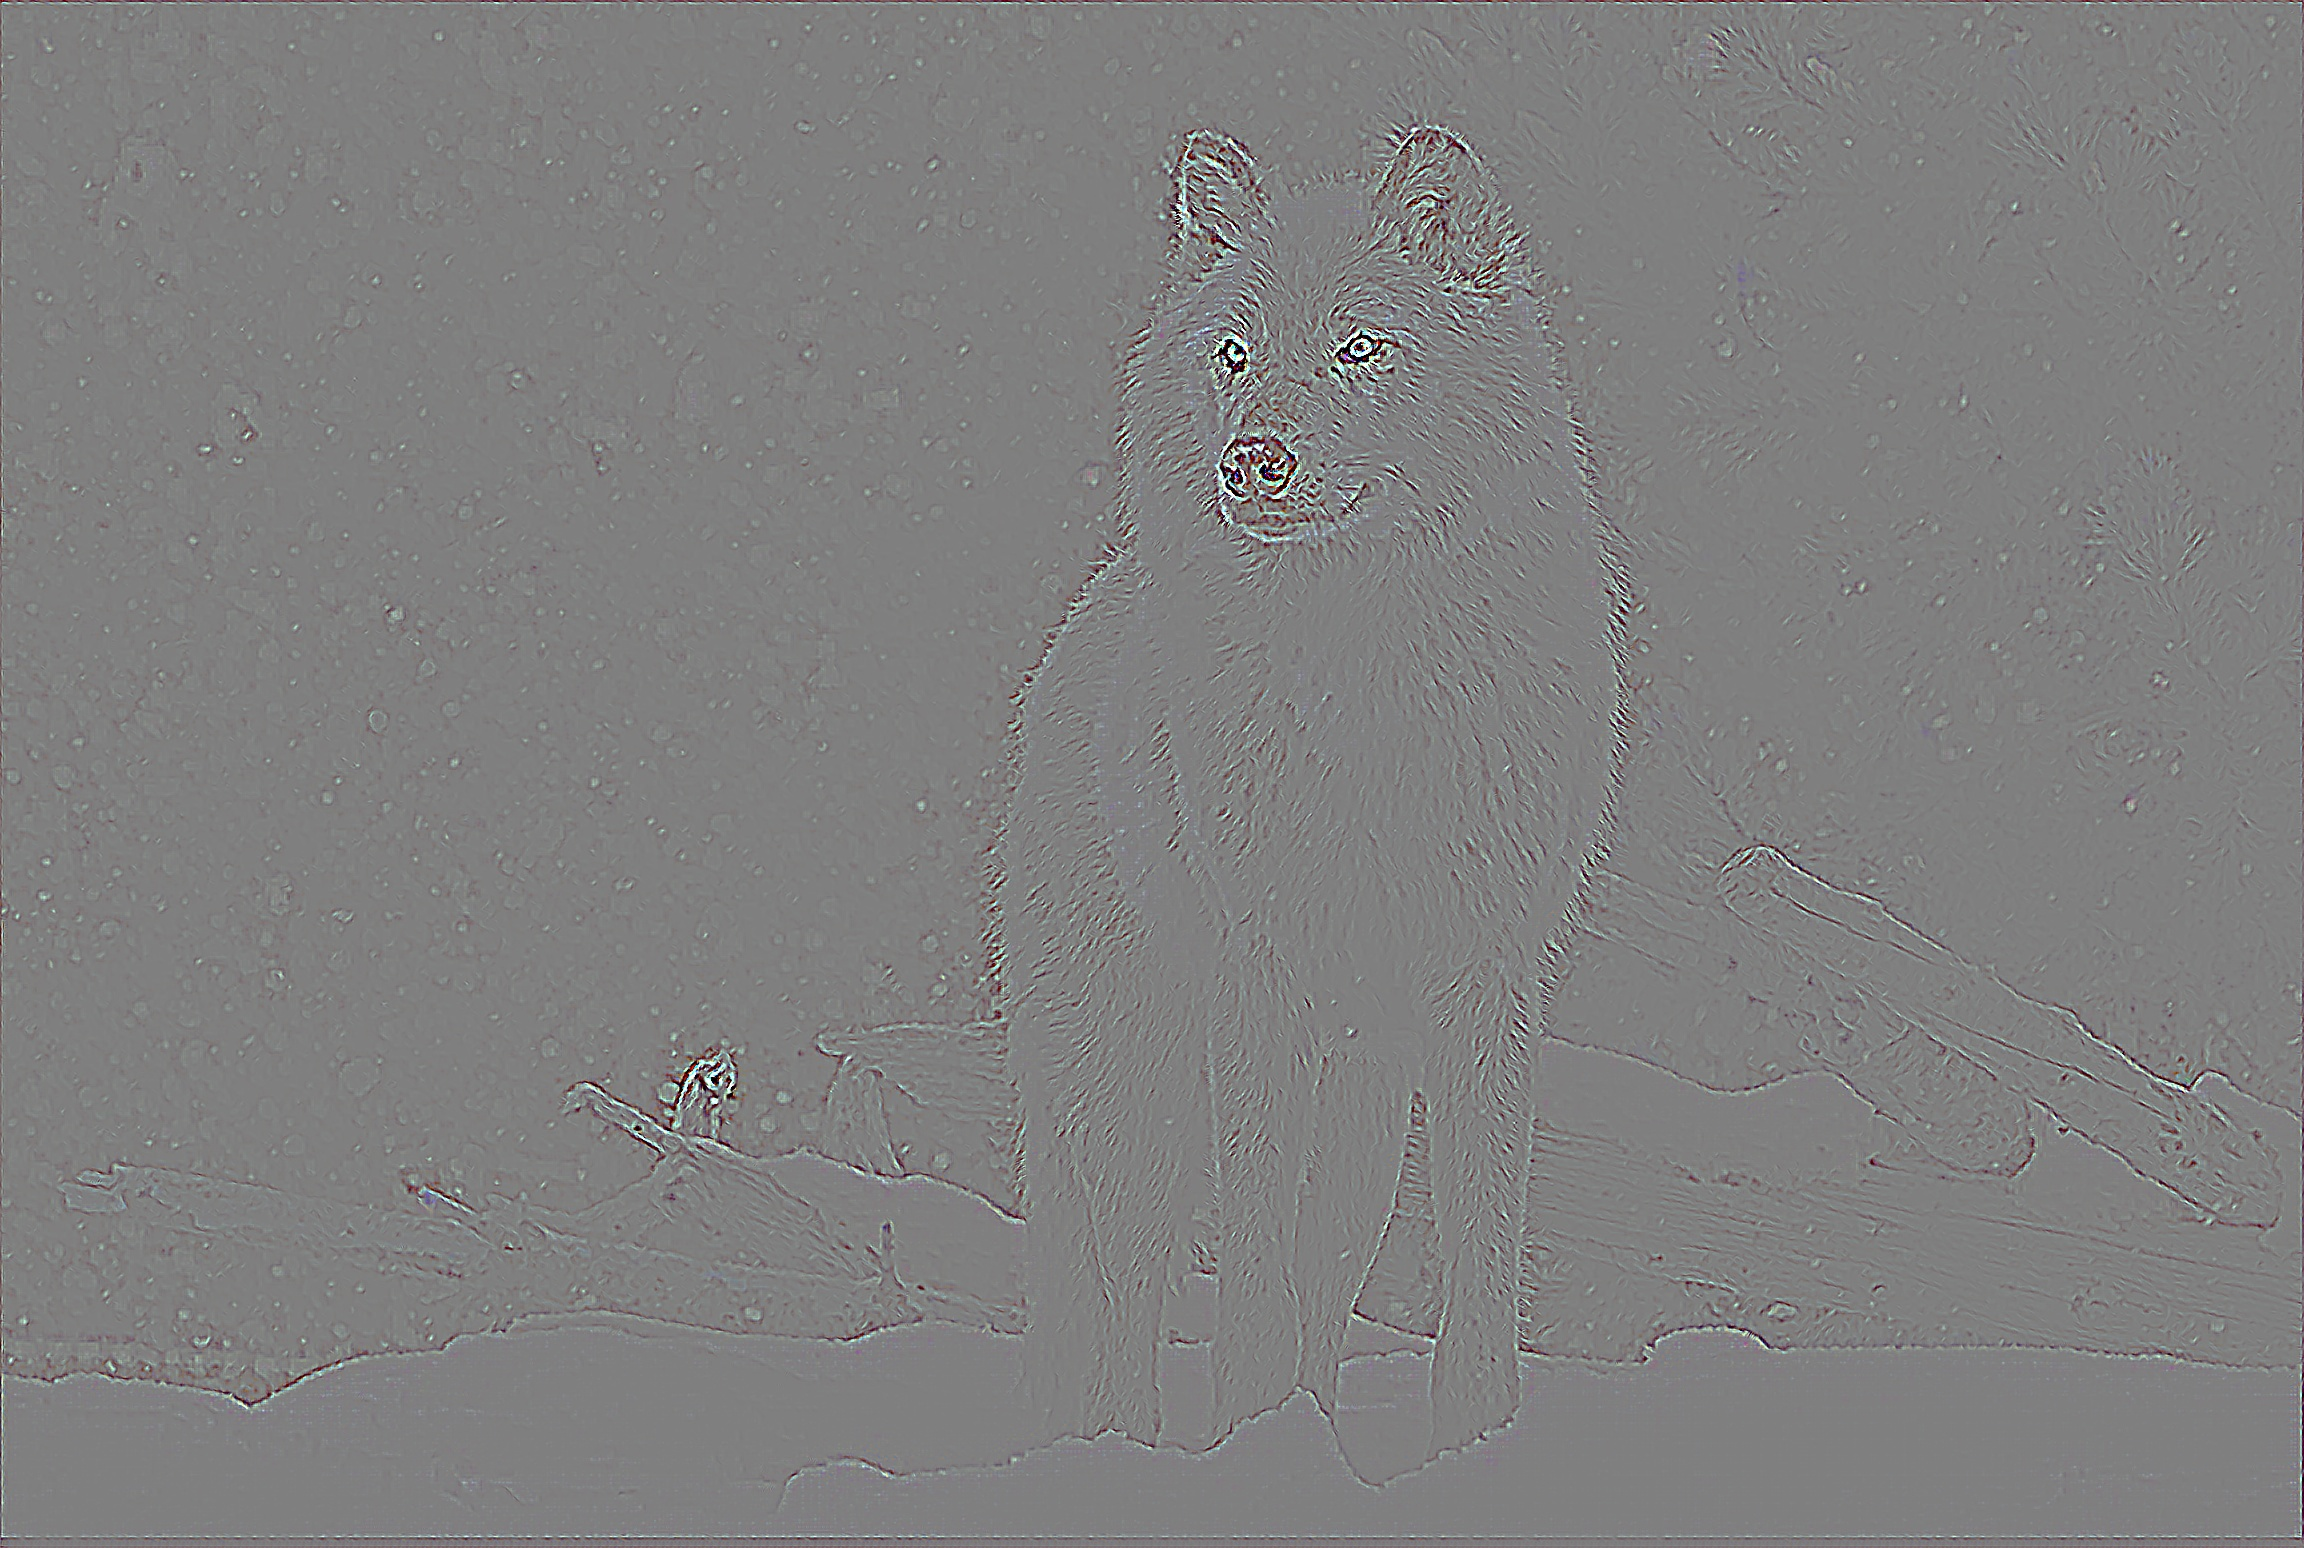

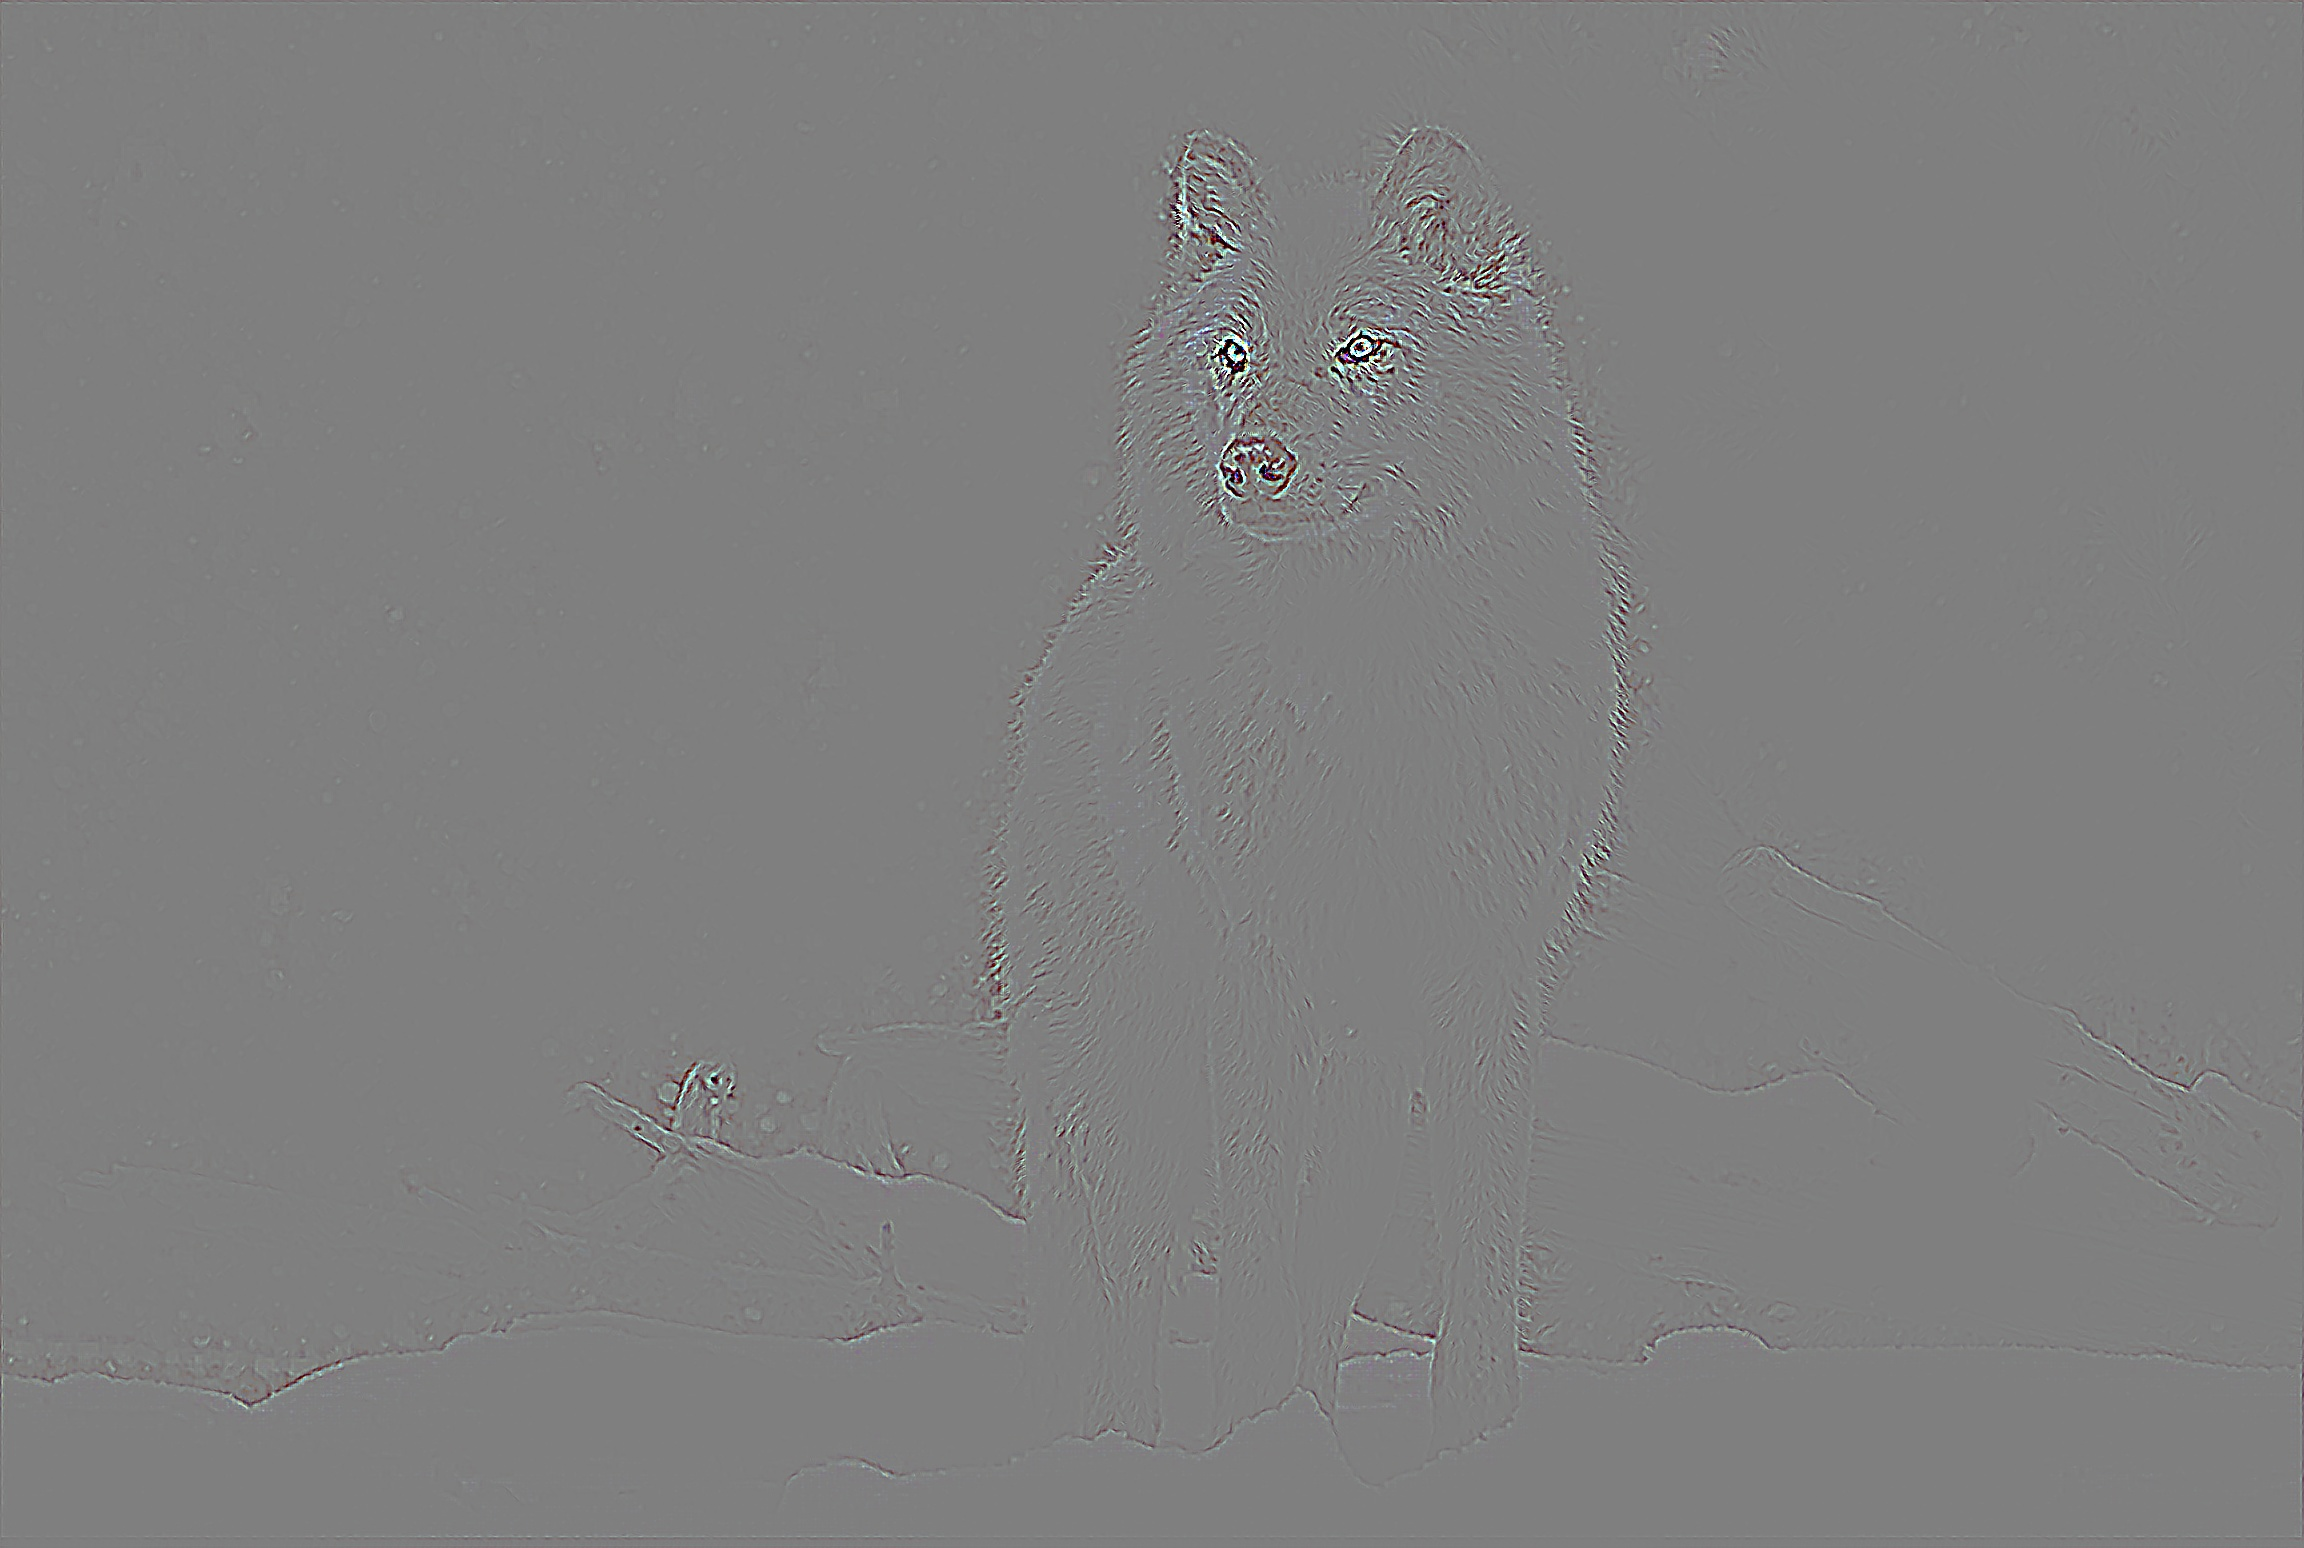

In [16]:
#@title Dislpay grad-cam result
from IPython.display import Image, display
display(Image('cam.jpg'))
display(Image('gb.jpg'))
display(Image('cam_gb.jpg'))